In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
summary_stats = pd.read_pickle('EventR2_GRU_summary_df0_10.0_scale0_0.06_l2_0.0_do_0.5.pkl')
comp_data = pd.read_pickle('EventR2_GRU_comp_df0_10.0_scale0_0.06_l2_0.0_do_0.5.pkl')
comp_data = pd.concat([comp_data[0][ii] for ii in range(len(comp_data[0]))])

/Users/nicholasfranklin/anaconda3/envs/sem/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


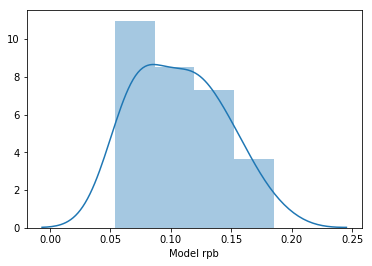

In [3]:
sns.distplot(summary_stats['Model rpb'])

In [4]:
set(comp_data.Video)

{'Bed', 'Dishes', 'Sax'}

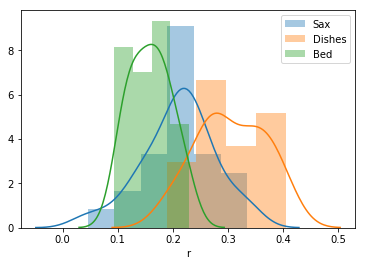

In [5]:
#pull the r-squares for each video seperately 
videos = set(comp_data.Video)

rs = []
for vid in videos:
    for b in set(comp_data.Batch):
        vec = (comp_data.Batch == b) & (comp_data.Video == vid)
        rs.append({
             'Video': vid,
             'Batch':b,
             'r': np.corrcoef(comp_data.loc[vec, 'Boundary-LogProb'],
                              comp_data.loc[vec, 'Human Boundary Freq'])[0][1]
         })
rs = pd.DataFrame(rs)

for v in set(comp_data.Video):
    sns.distplot(rs.loc[rs.Video == v, 'r'], label=v)
plt.legend()

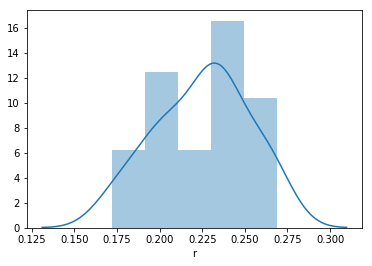

In [6]:
sns.distplot(rs.groupby('Batch').mean()['r'])

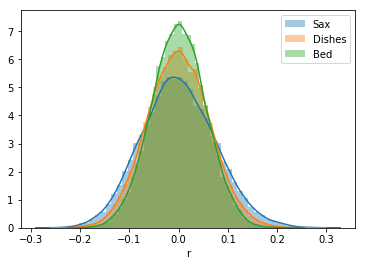

In [7]:
from tqdm import tnrange
n_permutations = 1000

rs_permuted = []
comp_data.index = range(len(comp_data))
for p in tnrange(n_permutations):
    
    # permute the whole range
    comp_data_permuted = comp_data.loc[np.random.permutation(range(len(comp_data))), :].copy()

    for vid in videos:
        for b in set(comp_data.Batch):
            vec = (comp_data.Batch == b) & (comp_data.Video == vid)
            rs_permuted.append({
                 'Video': vid,
                 'Batch':b,
                 'r': np.corrcoef(comp_data_permuted.loc[vec, 'Boundary-LogProb'].values,
                                  comp_data.loc[vec, 'Human Boundary Freq'].values)[0][1],
                'Permutation': p,
            })
rs_permuted = pd.DataFrame(rs_permuted)

for v in set(comp_data.Video):
    sns.distplot(rs_permuted.loc[rs_permuted.Video == v, 'r'], label=v)
plt.legend()

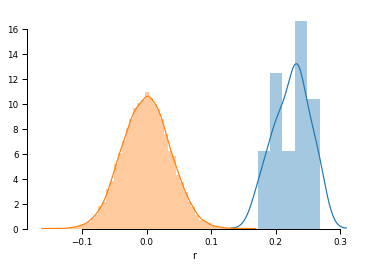

In [8]:
with sns.plotting_context('paper'):
    sns.distplot(rs.groupby('Batch').mean()['r'], label='Model')
    sns.distplot(rs_permuted.groupby(['Batch', 'Permutation']).mean()['r'], label='Permutation Distribution')
    sns.despine(trim=True)

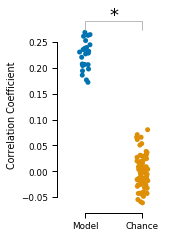

In [9]:
perms_to_show = 3

all_rs = pd.DataFrame({
    'Correlation Coefficient': np.concatenate([rs.groupby('Batch').mean()['r'], 
                         rs_permuted.groupby(['Batch', 'Permutation']).mean()['r'].values[:25*perms_to_show]]),
    'cond': ['Model'] * 25 + ['Chance'] * 25 * perms_to_show
})

with sns.plotting_context('paper'):
    g = sns.catplot(data=all_rs, x='cond', y='Correlation Coefficient', dodge=False,
                kind='strip', height=3.5, aspect=0.75, palette='colorblind')
    
    y_max = np.max(all_rs['Correlation Coefficient'])
    y_min = np.min(all_rs['Correlation Coefficient'])
    g.ax.text(0.5, y_max + abs(y_max - y_min)*0.1, "*",
       horizontalalignment='center',
       verticalalignment='center', size=18)
    
    g.ax.annotate("", xy=(0, y_max), xycoords='data',
           xytext=(1, y_max), textcoords='data',
           arrowprops=dict(arrowstyle="-", ec='#aaaaaa',
                           connectionstyle="bar,fraction=0.2"))
    g.ax.set_xlabel('')
    
    sns.despine(trim=True)

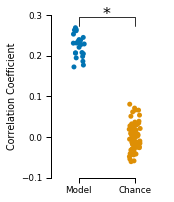

In [10]:
with sns.plotting_context('paper'):
    fig, ax = plt.subplots(figsize=(2, 3.0))
    sns.stripplot(data=all_rs, x='cond', y='Correlation Coefficient', dodge=False,
                ax=ax, palette='colorblind')
    
    y_max = np.max(all_rs['Correlation Coefficient'])
    y_min = np.min(all_rs['Correlation Coefficient'])
    ax.text(0.5, y_max + abs(y_max - y_min)*0.1, "*",
       horizontalalignment='center',
       verticalalignment='center', size=16)
    
    ax.annotate("", xy=(0, y_max), xycoords='data',
           xytext=(1, y_max), textcoords='data',
           arrowprops=dict(arrowstyle="-", ec='k',
                           connectionstyle="bar,fraction=0.2"))
    ax.set_xlabel('')
    ax.set_yticks(np.arange(-.1, .31, .1))
    sns.despine(trim=True)

In [11]:
from scipy.stats import ttest_ind
ttest_ind(rs.groupby('Batch').mean()['r'], rs_permuted.groupby(['Batch', 'Permutation']).mean()['r'].values)

Ttest_indResult(statistic=30.38407365118168, pvalue=3.69498921775111e-199)

In [12]:
comp_data[:5]

,Batch,Boundary-LogProb,Human Boundary Freq,MAP-Boundaries,Video,t
0,0,-3.401197,0.020833,False,Sax,0
1,0,-110.868736,0.000000,False,Sax,1
2,0,-138.977982,0.000000,False,Sax,2
3,0,-156.583757,0.208333,False,Sax,3
4,0,-145.324579,0.166667,False,Sax,4


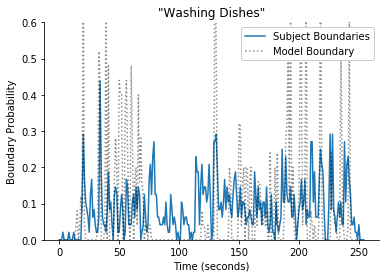

In [41]:
batch = 4

# model_boundaries = comp_data.loc[(comp_data.Batch == batch) & (comp_data.Video == 'Dishes'), "MAP-Boundaries"].values
subj_boundaries = comp_data.loc[(comp_data.Batch == batch) & (comp_data.Video == 'Dishes'), "Human Boundary Freq"].values

# # Figure 1: Example of segmentation
# plt.figure(figsize=(5.0, 5.0))
# ax = plt.subplot2grid((2, 2), (0, 0), colspan=2)

plt.plot(subj_boundaries, label='Subject Boundaries')
plt.xlabel('Time (seconds)')
plt.ylabel('Boundary Probability')

    
model_boundaries = comp_data.loc[(comp_data.Video == 'Dishes'), 
                                 :].groupby('t').mean()["MAP-Boundaries"].values
plt.plot(model_boundaries, 'k:', alpha=0.45, label='Model Boundary')


plt.legend(loc='upper right', framealpha=1.0)
plt.ylim([0, 0.6])
plt.title('"Washing Dishes"')
sns.despine()

In [43]:

print subj_frequencies[np.flip(np.argsort(subj_boundaries))][:10]
print np.flip(np.argsort(subj_boundaries))[:10]
print model_boundaries[np.flip(np.argsort(subj_boundaries))][:10]



[0.4375     0.29166667 0.29166667 0.29166667 0.29166667 0.27083333
 0.27083333 0.27083333 0.27083333 0.27083333]
[ 34 226 228  20 131  79 210 211 238 130]
[0.44 0.   0.08 0.68 0.48 0.   0.08 0.04 0.   0.96]


In [47]:
subj_boundaries[79]

0.2708333333333333

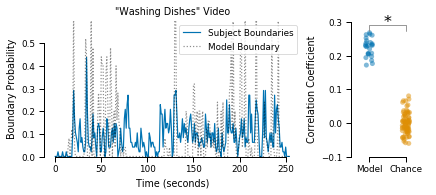

In [18]:
import matplotlib.gridspec as gridspec

with sns.plotting_context('paper'):
    plt.figure(figsize=(6.825, 2.5))


    gs = gridspec.GridSpec(1, 2,
                           width_ratios=[3.5, 1],
                           )
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])

    ax1.plot(subj_boundaries, label='Subject Boundaries', color=sns.color_palette('colorblind')[0])
    ax1.set_xlabel('Time (seconds)')
    ax1.set_ylabel('Boundary Probability')
    ax1.plot(model_boundaries, 'k:', alpha=0.45, label='Model Boundary')



    ax1.legend(loc='upper right', framealpha=.85)
    ax1.set_ylim([0, 0.6])
    ax1.set_title('"Washing Dishes" Video')
    sns.despine()


    sns.stripplot(data=all_rs, x='cond', y='Correlation Coefficient', dodge=False,
                ax=ax2, palette='colorblind', alpha=0.5)

    y_max = np.max(all_rs['Correlation Coefficient'])
    y_min = np.min(all_rs['Correlation Coefficient'])
    ax2.text(0.5, y_max + abs(y_max - y_min)*0.1, "*",
       horizontalalignment='center',
       verticalalignment='center', size=16)

    ax2.annotate("", xy=(0, y_max), xycoords='data',
           xytext=(1, y_max), textcoords='data',
           arrowprops=dict(arrowstyle="-", ec='grey',
                           connectionstyle="bar,fraction=0.2"))
    ax2.set_xlabel('')
    ax2.set_yticks(np.arange(-.1, .31, .1))
    sns.despine(trim=True)

    plt.subplots_adjust(wspace=0.3)
    plt.savefig('VideoData.png', dpi=300, bbox_inches='tight')

In [19]:
help(plt.subplots_adjust)

Help on function subplots_adjust in module matplotlib.pyplot:

subplots_adjust(*args, **kwargs)
    Tune the subplot layout.
    
    call signature::
    
      subplots_adjust(left=None, bottom=None, right=None, top=None,
                      wspace=None, hspace=None)
    
    The parameter meanings (and suggested defaults) are::
    
      left  = 0.125  # the left side of the subplots of the figure
      right = 0.9    # the right side of the subplots of the figure
      bottom = 0.1   # the bottom of the subplots of the figure
      top = 0.9      # the top of the subplots of the figure
      wspace = 0.2   # the amount of width reserved for space between subplots,
                     # expressed as a fraction of the average axis width
      hspace = 0.2   # the amount of height reserved for space between subplots,
                     # expressed as a fraction of the average axis height
    
    The actual defaults are controlled by the rc file



In [20]:
def get_point_biserial(boundaries_binned, binned_comp):
    M_1 = np.mean(binned_comp[boundaries_binned == 1])
    M_0 = np.mean(binned_comp[boundaries_binned == 0])

    n_1 = np.sum(boundaries_binned == 1)
    n_0 = np.sum(boundaries_binned == 0)
    n = n_1 + n_0

    s = np.std(binned_comp)
    r_pb = (M_1 - M_0) / s * np.sqrt(n_1 * n_0 / (float(n)**2))
    return r_pb



In [49]:
# calculate the maximum possible point-biserial correlation coefficient.  



_fake_rbp = []

for vid in videos:
    vec = (comp_data.Batch == 0) & (comp_data.Video == vid)
    

    subj_boundaries = comp_data.loc[(comp_data.Batch == batch) &
                                    (comp_data.Video == vid), "Human Boundary Freq"].values
    
    subj_frequencies = comp_data.loc[vec, 'Human Boundary Freq'].values
    
    sorted_subj_boundaries = np.flip(np.argsort(subj_boundaries))
    
    for n, t in enumerate(sorted_subj_boundaries):
        fake_boundaries = np.zeros(len(subj_boundaries), dtype=bool)
        fake_boundaries[t] = True

        _fake_rbp += [{
            'Video': vid,
            'r-pb': get_point_biserial(fake_boundaries, subj_frequencies),
            'n-boundaries': n
        }]


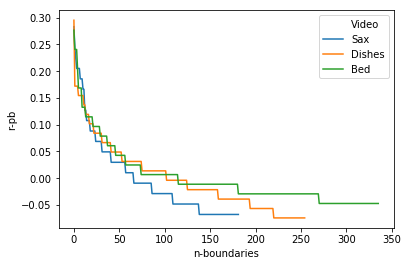

In [54]:
sns.lineplot(data=pd.DataFrame(_fake_rbp), x='n-boundaries', y='r-pb', hue='Video')

In [52]:
pd.DataFrame(_fake_rbp).groupby('Video').max()

,n-boundaries,r-pb
Video,,
Bed,335,0.276653
Dishes,254,0.295307
Sax,181,0.283233


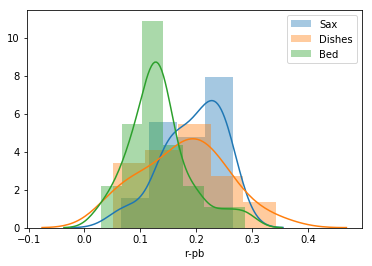

In [55]:


#pull the r-squares for each video seperately 
videos = set(comp_data.Video)

rpbs = []
for vid in videos:
    for b in set(comp_data.Batch):
        vec = (comp_data.Batch == b) & (comp_data.Video == vid)
        rpbs.append({
             'Video': vid,
             'Batch':b,
             'r-pb': get_point_biserial(comp_data.loc[vec, 'MAP-Boundaries'],
                              comp_data.loc[vec, 'Human Boundary Freq'])
         })
rpbs = pd.DataFrame(rpbs)

for v in set(comp_data.Video):
    sns.distplot(rpbs.loc[rpbs.Video == v, 'r-pb'], label=v)
plt.legend()

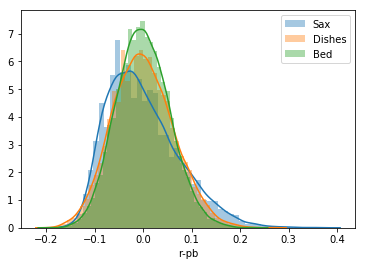

In [56]:

rpbs_permuted = []
comp_data.index = range(len(comp_data))
for p in tnrange(n_permutations):
    
    # permute the whole range
    comp_data_permuted = comp_data.loc[np.random.permutation(range(len(comp_data))), :].copy()

    for vid in videos:
        for b in set(comp_data.Batch):
            vec = (comp_data.Batch == b) & (comp_data.Video == vid)
            vec_p = (comp_data_permuted.Batch == b) & (comp_data_permuted.Video == vid)
            rpbs_permuted.append({
                 'Video': vid,
                 'Batch':b,
                 'r-pb': get_point_biserial(comp_data_permuted.loc[vec_p, 'MAP-Boundaries'].values,
                                  comp_data.loc[vec, 'Human Boundary Freq'].values),
                'Permutation': p,
            })
rpbs_permuted = pd.DataFrame(rpbs_permuted)

for v in set(comp_data.Video):
    sns.distplot(rpbs_permuted.loc[rpbs_permuted.Video == v, 'r-pb'], label=v)
plt.legend()

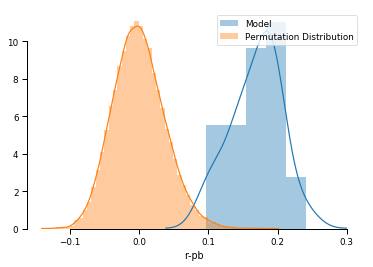

In [57]:
with sns.plotting_context('paper'):
    sns.distplot(rpbs.groupby('Batch').mean()['r-pb'], label='Model')
    sns.distplot(rpbs_permuted.groupby(['Batch', 'Permutation']).mean()['r-pb'], label='Permutation Distribution')
    sns.despine(trim=True)
    plt.legend()

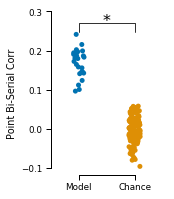

In [58]:
perms_to_show = 5

all_rpbs = pd.DataFrame({
    'Point Bi-Serial Corr': np.concatenate([rpbs.groupby('Batch').mean()['r-pb'], 
                         rpbs_permuted.groupby(['Batch', 'Permutation']).mean()['r-pb'].values[:25*perms_to_show]]),
    'cond': ['Model'] * 25 + ['Chance'] * 25 * perms_to_show
})

with sns.plotting_context('paper'):
    fig, ax = plt.subplots(figsize=(2, 3.0))
    sns.stripplot(data=all_rpbs, x='cond', y='Point Bi-Serial Corr', dodge=False,
                ax=ax, palette='colorblind')
    
    y_max = np.max(all_rpbs['Point Bi-Serial Corr'])
    y_min = np.min(all_rpbs['Point Bi-Serial Corr'])
    ax.text(0.5, y_max + abs(y_max - y_min)*0.1, "*",
       horizontalalignment='center',
       verticalalignment='center', size=16)
    
    ax.annotate("", xy=(0, y_max), xycoords='data',
           xytext=(1, y_max), textcoords='data',
           arrowprops=dict(arrowstyle="-", ec='k',
                           connectionstyle="bar,fraction=0.2"))
    ax.set_xlabel('')
    ax.set_yticks(np.arange(-.1, .31, .1))
    sns.despine(trim=True)

In [59]:
from scipy.stats import ttest_ind
ttest_ind(rpbs.groupby('Batch').mean()['r-pb'], rpbs_permuted.groupby(['Batch', 'Permutation']).mean()['r-pb'].values)

Ttest_indResult(statistic=22.662994283151534, pvalue=1.4128168430928402e-112)

In [60]:
def bin_times(array, max_seconds, bin_size=1.0):
    cumulative_binned = [np.sum(array <= t0 * 1000) for t0 in np.arange(bin_size, max_seconds + bin_size, bin_size)]
    binned = np.array(cumulative_binned)[1:] - np.array(cumulative_binned)[:-1]
    binned = np.concatenate([[cumulative_binned[0]], binned])
    return binned


def load_comparison_data(data, bin_size=1.0):

    # Movie A is Saxaphone (185s long)
    # Movie B is making a bed (336s long)
    # Movie C is doing dishes (255s long)

    # here, we'll collapse over all of the groups (old, young; warned, unwarned) for now
    n_subjs = len(set(data.SubjNum))

    sax_times = np.sort(list(set(data.loc[data.Movie == 'A', 'MS']))).astype(np.float32)
    binned_sax = bin_times(sax_times, 185, bin_size) / np.float(n_subjs)

    bed_times = np.sort(list(set(data.loc[data.Movie == 'B', 'MS']))).astype(np.float32)
    binned_bed = bin_times(bed_times, 336, bin_size) / np.float(n_subjs)

    dishes_times = np.sort(list(set(data.loc[data.Movie == 'C', 'MS']))).astype(np.float32)
    binned_dishes = bin_times(dishes_times, 255, bin_size) / np.float(n_subjs)

    return binned_sax, binned_bed, binned_dishes

def get_subjs_rpb(data, bin_size=1.0):
    # get the grouped data
    #     binned_sax, binned_bed, binned_dishes = load_comparison_data(data)
    grouped_data = np.concatenate(load_comparison_data(data, bin_size=bin_size))

    r_pbs = []

    for sj in set(data.SubjNum):
        _binned_sax = bin_times(data.loc[(data.SubjNum == sj) & (data.Movie == 'A'), 'MS'], 185, bin_size)
        _binned_bed = bin_times(data.loc[(data.SubjNum == sj) & (data.Movie == 'B'), 'MS'], 336, bin_size)
        _binned_dishes = bin_times(data.loc[(data.SubjNum == sj) & (data.Movie == 'C'), 'MS'], 255, bin_size)
        subs = np.concatenate([_binned_sax, _binned_bed, _binned_dishes])

        r_pbs.append(get_point_biserial(subs, grouped_data))
    return r_pbs

data = pd.read_csv('data/zachs2006_data021011.dat', delimiter='\t')
subj_rpb = get_subjs_rpb(data)

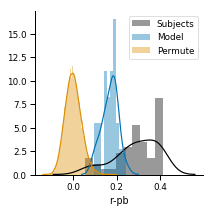

In [61]:
sns.set_palette('colorblind')

with sns.plotting_context('paper'):
    fig, ax = plt.subplots(figsize=(3,3))
    sns.distplot(subj_rpb, label='Subjects', color='k', bins=10, ax=ax)
    sns.distplot(rpbs.groupby('Batch').mean()['r-pb'], label='Model', bins=10, ax=ax)
    sns.distplot(rpbs_permuted.groupby(['Batch', 'Permutation']).mean()['r-pb'].values, label='Permute', 
                 bins=100, ax=ax)
    plt.legend()
    sns.despine(trim=False)



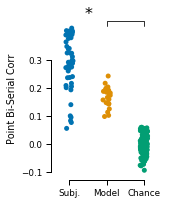

In [62]:
perms_to_show = 5

all_rpbs = pd.DataFrame({
    'Point Bi-Serial Corr': np.concatenate([
        rpbs.groupby('Batch').mean()['r-pb'], 
        rpbs_permuted.groupby(['Batch', 'Permutation']).mean()['r-pb'].values[:25*perms_to_show],
        subj_rpb
                                           ]),
                
    'cond': ['Model'] * 25 + ['Chance'] * 25 * perms_to_show  + ['Subj.'] * len(subj_rpb)
})

with sns.plotting_context('paper'):
    fig, ax = plt.subplots(figsize=(2, 3.0))
    sns.stripplot(data=all_rpbs, x='cond', y='Point Bi-Serial Corr', dodge=False,
                ax=ax, palette='colorblind', order=['Subj.', 'Model', 'Chance'])
    
    y_max = np.max(all_rpbs['Point Bi-Serial Corr'])
    y_min = np.min(all_rpbs['Point Bi-Serial Corr'])
    ax.text(0.5, y_max + abs(y_max - y_min)*0.1, "*",
       horizontalalignment='center',
       verticalalignment='center', size=16)
    
    ax.annotate("", xy=(1, y_max), xycoords='data',
           xytext=(2, y_max), textcoords='data',
           arrowprops=dict(arrowstyle="-", ec='k',
                           connectionstyle="bar,fraction=0.2"))
    ax.set_xlabel('')
    ax.set_yticks(np.arange(-.1, .31, .1))
    sns.despine(trim=True)

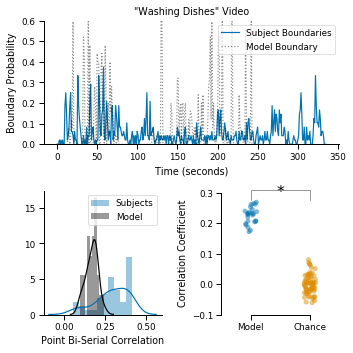

In [63]:
import matplotlib.gridspec as gridspec

with sns.plotting_context('paper'):
#     plt.figure(figsize=( 6.875 , 2.5))
    plt.figure(figsize=(5.0, 5.0))
    ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((2, 2), (1, 0), colspan=1)
    ax3 = plt.subplot2grid((2, 2), (1, 1), colspan=1)
    
    # plot the example
    ax1.plot(subj_boundaries, label='Subject Boundaries', color=sns.color_palette('colorblind')[0])
    ax1.set_xlabel('Time (seconds)')
    ax1.set_ylabel('Boundary Probability')
    ax1.plot(model_boundaries, 'k:', alpha=0.45, label='Model Boundary')


    ax1.legend(loc='upper right', framealpha=.75)
    ax1.set_ylim([0, 0.6])
    ax1.set_title('"Washing Dishes" Video')
    sns.despine()
    
    # plot the point-biserial
    sns.distplot(subj_rpb, label='Subjects', bins=10, ax=ax2)
    sns.distplot(rpbs.groupby('Batch').mean()['r-pb'], label='Model', bins=10, ax=ax2, color='k')
    ax2.legend()
    sns.despine(trim=False, ax=ax2)
    ax2.set_xlabel('Point Bi-Serial Correlation')
    

    # plot the r values
    sns.stripplot(data=all_rs, x='cond', y='Correlation Coefficient', dodge=False,
                ax=ax3, palette='colorblind', alpha=0.5)

    y_max = np.max(all_rs['Correlation Coefficient'])
    y_min = np.min(all_rs['Correlation Coefficient'])
    ax3.text(0.5, y_max + abs(y_max - y_min)*0.1, "*",
       horizontalalignment='center',
       verticalalignment='center', size=16)

    ax3.annotate("", xy=(0, y_max), xycoords='data',
           xytext=(1, y_max), textcoords='data',
           arrowprops=dict(arrowstyle="-", ec='grey',
                           connectionstyle="bar,fraction=0.2"))
#     ax3.set_xticklabels(rotation=90)
    ax3.set_xlabel('')
    ax3.set_yticks(np.arange(-.1, .31, .1))
    sns.despine(trim=True,ax=ax3)

    plt.subplots_adjust(hspace=0.4, wspace=0.5)
#     plt.savefig('VideoData.png', dpi=300, bbox_inches='tight')

    plt.tight_layout()

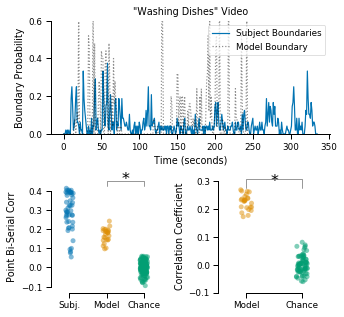

In [64]:
#     plt.figure(figsize=(6.825, 2.5))


#     gs = gridspec.GridSpec(1, 2,
#                            width_ratios=[3.5, 1],
#                            )
#     ax1 = plt.subplot(gs[0])
#     ax2 = plt.subplot(gs[1])

import matplotlib.gridspec as gridspec

with sns.plotting_context('paper'):
#     plt.figure(figsize=( 6.875 , 2.5))
#     gs = gridspec.GridSpec(1, 3, width_ratios=[2.5, 1.25, 1.25])

#     ax1 = plt.subplot(gs[0])
#     ax2 = plt.subplot(gs[1])
#     ax3 = plt.subplot(gs[2])
    plt.figure(figsize=(5.0, 5.0))
    ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((2, 2), (1, 0), colspan=1)
    ax3 = plt.subplot2grid((2, 2), (1, 1), colspan=1)



    # plot the example
    ax1.plot(subj_boundaries, label='Subject Boundaries', color=sns.color_palette('colorblind')[0])
    ax1.set_xlabel('Time (seconds)')
    ax1.set_ylabel('Boundary Probability')
    ax1.plot(model_boundaries, 'k:', alpha=0.45, label='Model Boundary')

    ax1.legend(loc='upper right', framealpha=.75)
    ax1.set_ylim([0, 0.6])
    ax1.set_title('"Washing Dishes" Video')
    sns.despine()
    
    # plot the point-biserial
#     sns.distplot(subj_rpb, label='Subjects', bins=10, ax=ax2)
#     sns.distplot(rpbs.groupby('Batch').mean()['r-pb'], label='Model', bins=10, ax=ax2, color='k')
#     ax2.legend()
#     sns.despine(trim=False, ax=ax2)
#     ax2.set_xlabel('Point Bi-Serial Correlation')
    g= sns.stripplot(data=all_rpbs, x='cond', y='Point Bi-Serial Corr', dodge=False,
                ax=ax2, palette='colorblind', order=['Subj.', 'Model', 'Chance'], 
                 alpha=0.5)
#     g.set_xticklabels(g.axes.get_xticklabels(), rotation=90)
    y_max = np.max(all_rpbs['Point Bi-Serial Corr'])
    y_min = np.min(all_rpbs['Point Bi-Serial Corr'])
    ax2.text(1.5, y_max + abs(y_max - y_min)*0.1, "*",
           horizontalalignment='center',
           verticalalignment='center', size=16)
    ax2.set_xlabel('')

    ax2.annotate("", xy=(1, y_max), xycoords='data',
           xytext=(2, y_max), textcoords='data',
           arrowprops=dict(arrowstyle="-", ec='grey',
                           connectionstyle="bar,fraction=0.2"))
    sns.despine(trim=True, ax=ax2)
    
    

    # plot the r values
    g = sns.stripplot(data=all_rs, x='cond', y='Correlation Coefficient', dodge=False,
                ax=ax3, palette=sns.color_palette('colorblind')[1:], alpha=0.5)

    y_max = np.max(all_rs['Correlation Coefficient'])
    y_min = np.min(all_rs['Correlation Coefficient'])
    ax3.text(0.5, y_max + abs(y_max - y_min)*0.1, "*",
       horizontalalignment='center',
       verticalalignment='center', size=16)
#     g.set_xticklabels(g.axes.get_xticklabels(), rotation=90)


    ax3.annotate("", xy=(0, y_max), xycoords='data',
           xytext=(1, y_max), textcoords='data',
           arrowprops=dict(arrowstyle="-", ec='grey',
                           connectionstyle="bar,fraction=0.2"))
#     ax3.set_xticklabels(rotation=90)
    ax3.set_xlabel('')
    ax3.set_yticks(np.arange(-.1, .31, .1))
    sns.despine(trim=True,ax=ax3)

    plt.subplots_adjust(hspace=0.4, wspace=0.5)

#     plt.tight_layout()
    plt.savefig('VideoData.png', dpi=300, bbox_inches='tight')

In [65]:
g.axes.get_xticklabels()[1]

Text(1,0,'Chance')

In [66]:
help(plt.tight_layout)

Help on function tight_layout in module matplotlib.pyplot:

tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)
    Automatically adjust subplot parameters to give specified padding.
    
    Parameters
    ----------
    pad : float
        padding between the figure edge and the edges of subplots, as a fraction of the font-size.
    h_pad, w_pad : float
        padding (height/width) between edges of adjacent subplots.
        Defaults to `pad_inches`.
    rect : if rect is given, it is interpreted as a rectangle
        (left, bottom, right, top) in the normalized figure
        coordinate that the whole subplots area (including
        labels) will fit into. Default is (0, 0, 1, 1).



In [67]:
ttest_ind(subj_rpb, rpbs.groupby('Batch').mean()['r-pb'].values)

Ttest_indResult(statistic=5.875764670614405, pvalue=1.2488604290700687e-07)

In [68]:
ttest_ind(rpbs_permuted.groupby(['Batch', 'Permutation']).mean()['r-pb'].values, 
          rpbs.groupby('Batch').mean()['r-pb'].values)

Ttest_indResult(statistic=-22.662994283151534, pvalue=1.4128168430928402e-112)